**NEEDS TO BE REWRITTEN**

# Simple porosity modeling

This notebooks shows how elastic properties of reservoir rocks vary upon a porosity change, without building a proper rock physics model first.

### References


* Internal (and unpublished) ENI report by Cristiana Panzeri, .
* Mavko, G., and T. Mukerji, 1995, Seismic pore space compressibility and Gassmann's relation: Geophysics, v. 60, no. 6, p. 1743–1749.
* Avseth, P., T. Mukerji, and G. Mavko, 2005, Quantitative Seismic Interpretation: Cambridge University Press.
* Simm, R. and Bacon, M., 2014, Seismic Amplitude: Cambridge University Press.
* Russell, B. H., T. Smith, and A. Hampson-Russell, 2007, The relationship between dry rock bulk modulus and porosity–an empirical study: CREWES Research Report, v. 19, p. 1–14.

### Idea

The original aim of the work by Cristiana was to investigate different ways to predicting the change of the elastic properties of a rock upon variations in porosity. This could be important in areas where lateral heterogeneity is high or simply when unexpected facies change lead to modification in the expected seismic amplitude signature which cannot be attributed to the most commonly assumed factor, i.e. fluid changes. She concluded that the "simple" (as defined in Simm & Bacon, pag. 170) model based on pore space modulus unvariance is the most accurate so I'll focus on this method for the moment and show how its Python implementation.

What we need to keep in mind is (as usual) the geological context; porosity variations could be due to different causes requiring different approaches. Reduction in porosity associated with an increase of cementing should be model differently from reduction in porosity associated with a deterioration of sorting. 

The important thing to point out is that proper porosity modeling is strictly speaking a rock physics problem, but the aim of this notebook is to demonstrate simpler (and possibly more robust) ways to do that.

### How to do it

The _pore stiffness method_ (Russell & Smith, 2007) is based on the following equation:

$$ \frac{1}{K_d} = \frac{1}{K_0} + \frac{\phi}{K_\phi} $$

which states that dry rock _compressibility_ (the inverse of bulk modulus or stiffness) can be expressed in terms of mineral and pore space compressibility. 

By inverting the above equation we can calculate pore space stiffness:

$$ K_\phi = \frac{\phi}{1/K_d - 1/K_0} $$

which is the same as:

$$ K_\phi = \frac{K_d \cdot K_0 \cdot \phi}{K_0 - K_d} $$

or (to bypass the intermediate calculation of $K_d$):

$$ K_\phi = \frac{\phi}{1/K_s -1/K_0} - \frac{K_0 \cdot K_f}{K_0 - K_f} $$

For _small_ porosity changes (i.e. max. 10%) in clean sands, it is assumed that $K_\phi$ and $K_d/\mu$ stay constant so that we can model the new dry rock and shear modulus with these equations:

$$ {K_d}^* = \Big( \frac{1}{K_0} + \frac{\phi^*}{K_\phi} \Big)^{-1} $$

$$ \mu^* = \mu \cdot \frac{{K_d}^*}{K_d} $$ 

**DA CONTROLLARE**

$$ K_{sat} = \frac{{K_d}^*+(1-{K_d}^*/K_0)^2}{\phi/K_f+(1-\phi)/K_0)-({K_d}^*/{K_0}^2)} $$

    rho_new = rho0*(1-phi_new)+rhof*phi_new
    vp_new = np.sqrt((Ksat_new+4/3*mu_new)/rho_new)
    vs_new = np.sqrt(mu_new/rho_new)


### How to do it (for larger porosity variations)

If the increase in porosity is larger than 10% then we cannot assume that pore space stiffness remains constant. We can either go for the more tricky route of rock physics modeling or the simpler dry rock modeling (Mavko & Mukerji, 1995; Avseth et al., 2005).

We plot porosity against normalized dry rock moduli ($K_d/K_0$) and derive a fit which connects the cleaner sand datapoints with the endpoint at zero porosity where mineral bulk modulus is equal to dry rock modulus ($K_d/K_0 = 1$). The model to fit the data can be:

* linear fit, for porosity variations controlled by diagenesis, e.g. the critical porosity model (Nur, 1992): $K_d/K_0 = - \phi / \phi_c +1$
* iso-stiffness fits, for porosity variations controlled by sorting: $K_d/K_0 = 1/1+c\phi$
* exponential fits: $K_d/K_0 = e^{-c\phi}$

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
# from ipywidgets import interact, interactive, fixed

In [2]:
# tmp=pd.read_csv('qsiwell5.csv', index_col=0)
# LL = tmp[(tmp.index>2100) & (tmp.index<2300)]

In [3]:
tmp=pd.read_csv('qsiwell2_frm.csv', index_col=0)
LL = tmp[(tmp.index>2100) & (tmp.index<2340)]

In [4]:
sh=LL.VSH>0.5
ss=LL.VSH<0.2

z,vp,vs,rho = LL.index[ss], LL.VP[ss], LL.VS[ss], LL.RHO[ss]*1e3
phi,vsh = LL.PHIE[ss], LL.VSH[ss]

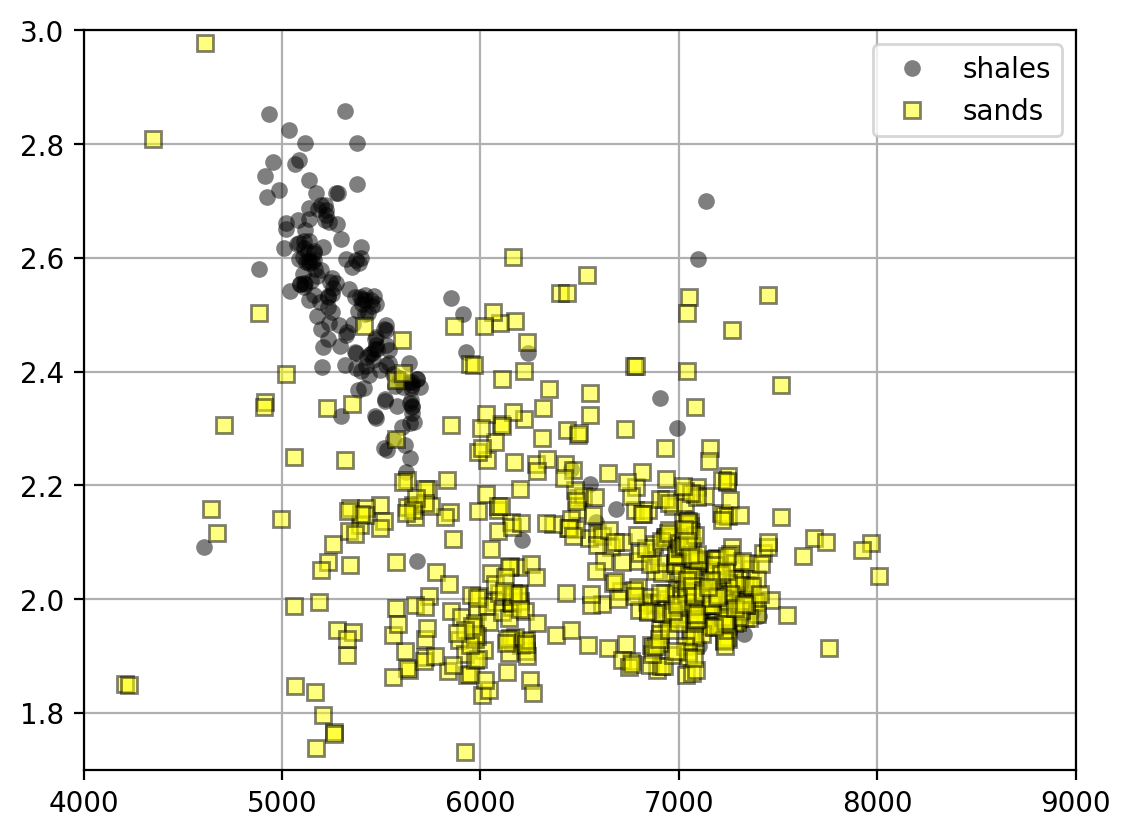

In [5]:
sty_ss = {'marker':'s','ls':'none','ms':6,'mec':'black','color':'yellow','alpha':0.5}
sty_ss1 = {'marker':'s','ls':'none','ms':6,'mec':'black','color':'green','alpha':0.5}
sty_sh = {'marker':'o','ls':'none','ms':6,'mec':'none','color':'black','alpha':0.5}
    
plt.figure()
plt.plot(LL.IP[sh] ,LL.VPVS[sh], label='shales', **sty_sh)
plt.plot(vp*rho/1e3, vp/vs, label='sands', **sty_ss)
plt.xlim(4000,9000)
plt.ylim(1.7,3)
plt.legend()
plt.grid()

### calculate $K_{dry}$ (with Gassmann's equation) and $K_\phi$

In [6]:
K0, rho0 = 37*1e9, 2650
Kf, rhof = 2.5*1e9, 1000

mu = rho*vs**2 
Ksat= rho*vp**2-(4/3)*mu

Kdry = (Ksat*((phi*K0)/Kf+1-phi)-K0) / ((phi*K0)/Kf+(Ksat/K0)-1-phi)
Kphi = phi/(1/Kdry - 1/K0)

# alternativa per calcolare direttamente Kphi senza il calcolo intermedio di Kdry
# Kphi= ( phi / (1/Ksat - 1/K0) ) - ( (K0*Kf) / (K0-Kf) )

### modify porosity by adding an extra x%

In [7]:
phi_new = phi+phi*.3

print('original porosity: {:.2f}'.format(np.mean(phi)))
print('modified porosity: {:.2f}'.format(np.mean(phi_new)))

original porosity: 0.31
modified porosity: 0.40


### calculate new $K_{dry}$

In [8]:
Kdry_new = (1/K0 + phi_new/Kphi)**-1

### calculate new velocities and densities

In [9]:
mu_new = mu*Kdry_new/Kdry
Ksat_new = Kdry_new+(1-Kdry_new/K0)**2 / ((phi/Kf)+((1-phi)/K0)-(Kdry_new/K0**2))

rho_new = rho0*(1-phi_new)+rhof*phi_new
vp_new = np.sqrt((Ksat_new+4/3*mu_new)/rho_new)
vs_new = np.sqrt(mu_new/rho_new)

Text(0.5, 0, 'Ip')

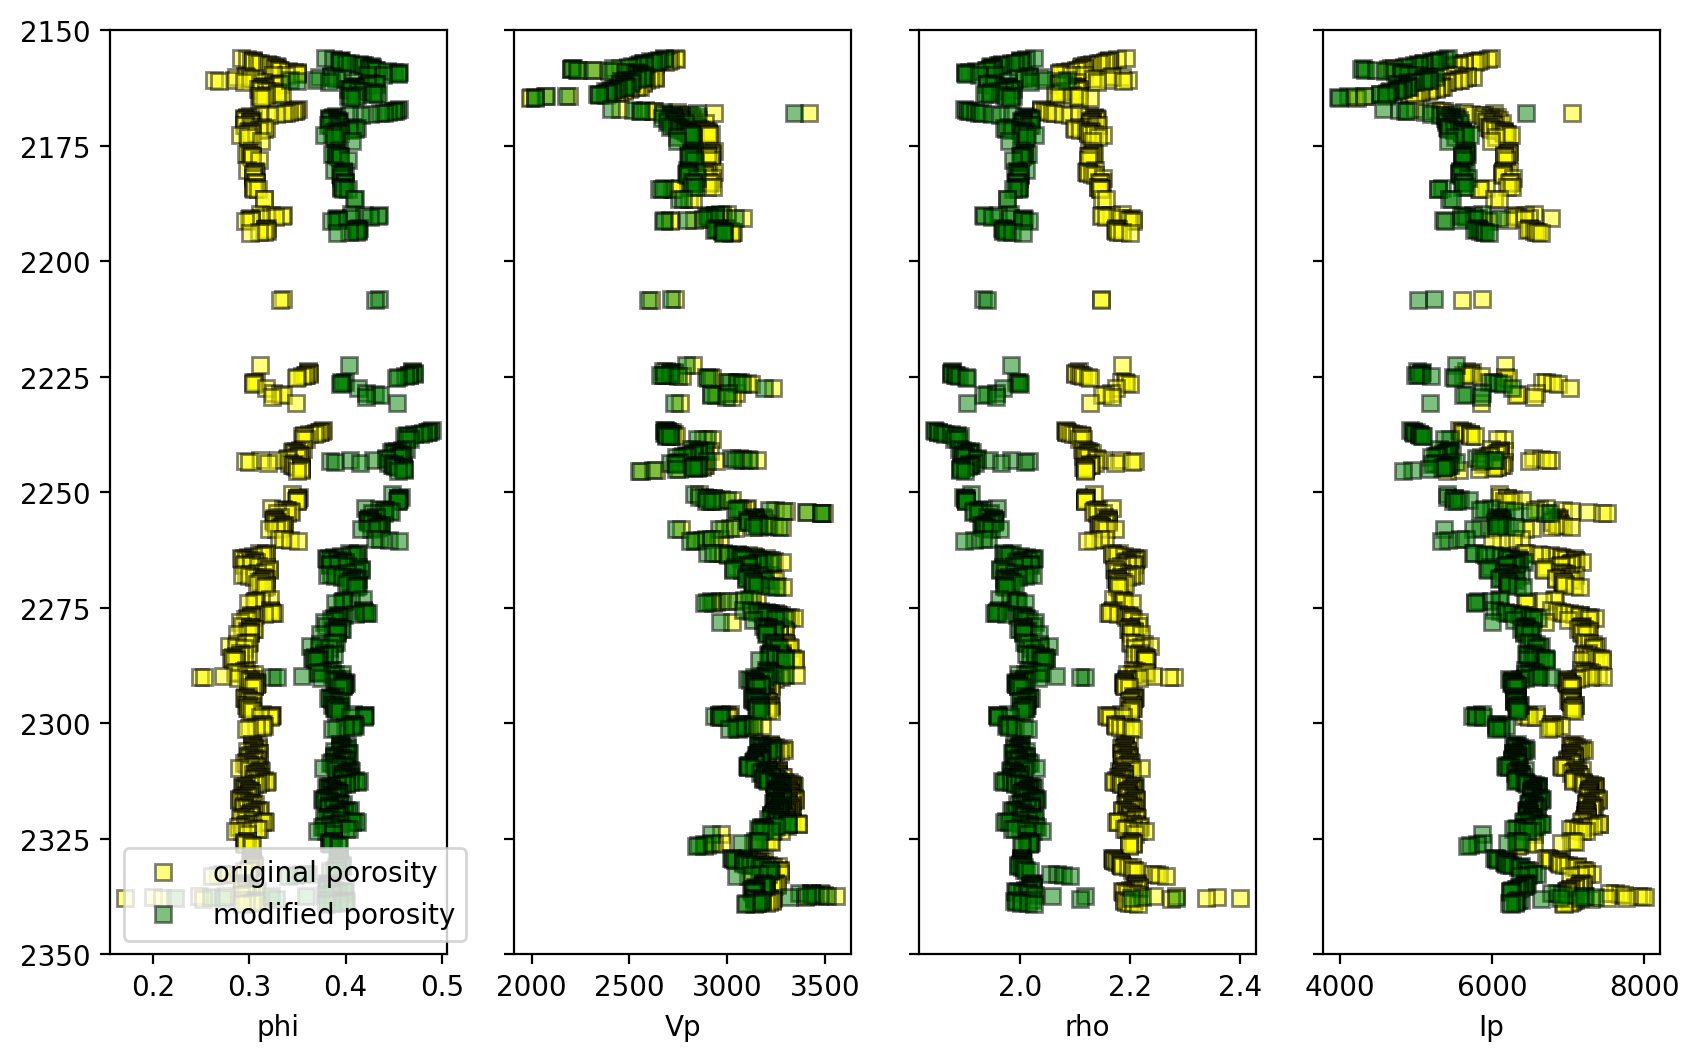

In [10]:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,6), sharey=True)

ax[0].plot(phi,z, label='original porosity', **sty_ss)
ax[0].plot(phi_new,z, label='modified porosity', **sty_ss1)
ax[0].set_xlabel('phi')
ax[0].legend()
ax[0].set_ylim(2350,2150)
ax[1].plot(vp,z, **sty_ss)
ax[1].plot(vp_new,z, **sty_ss1)
ax[1].set_xlabel('Vp')
ax[2].plot(rho/1e3,z, **sty_ss)
ax[2].plot(rho_new/1e3,z, **sty_ss1)
ax[2].set_xlabel('rho')
ax[3].plot(vp*rho/1e3,z, **sty_ss)
ax[3].plot(vp_new*rho_new/1e3,z, **sty_ss1)
ax[3].set_xlabel('Ip')

### print out some stats

In [11]:
print('initial Vp: {:.2f} m/s'.format(np.mean(vp)))
print('Vp after porosity variation: {:.2f} m/s'.format(np.mean(vp_new)))

print('initial density: {:.2f} g/cc'.format(np.mean(rho/1e3)))
print('density after porosity variation: {:.2f} g/cc'.format(np.mean(rho_new/1e3)))

print('initial AI: {:.2f} m/s*g/cc'.format(np.mean(vp*rho/1e3)))
print('AI after porosity variation: {:.2f}'.format(np.mean(vp_new*rho_new/1e3)))

initial Vp: 3051.65 m/s
Vp after porosity variation: 2998.08 m/s
initial density: 2.17 g/cc
density after porosity variation: 1.98 g/cc
initial AI: 6629.03 m/s*g/cc
AI after porosity variation: 5955.37


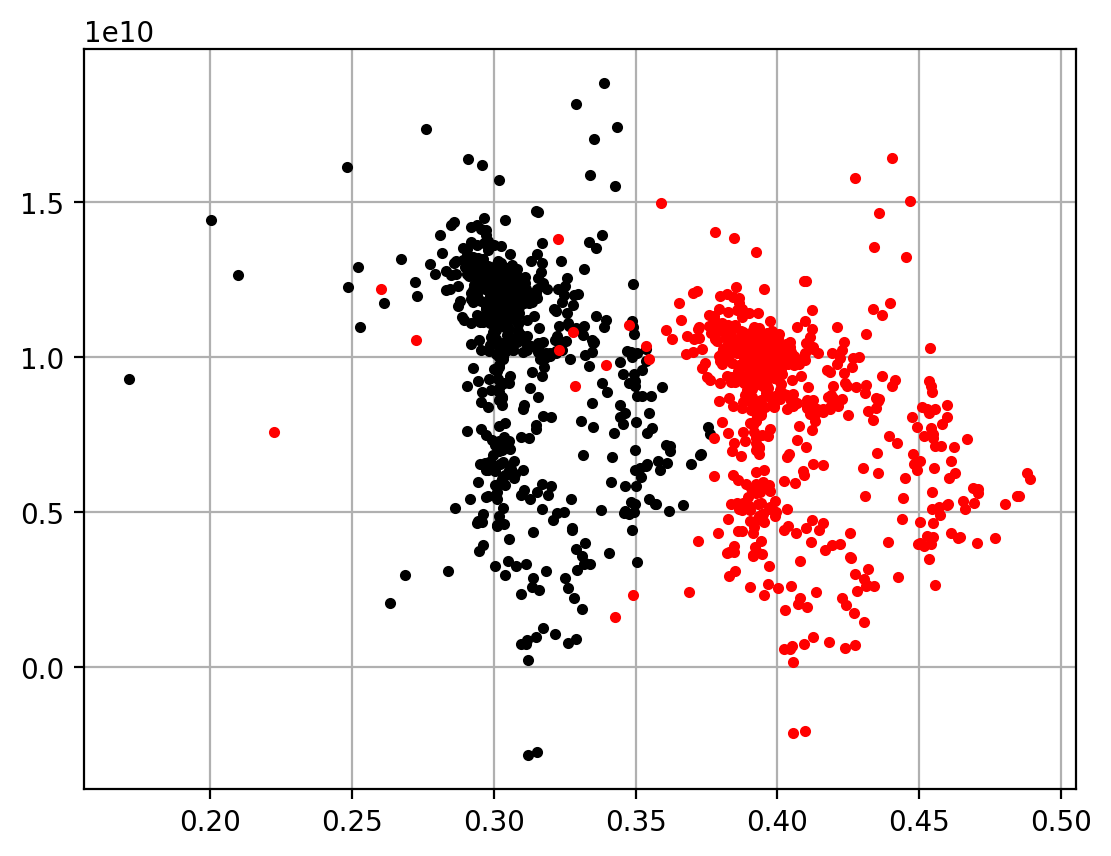

In [12]:
plt.figure()
plt.plot(phi,Kdry,'.k')
plt.plot(phi_new,Kdry_new,'.r')
plt.grid()

In [13]:
def vrh(volumes,k,mu):
    '''
    vrh (C) aadm 2015
    Calculates Voigt-Reuss-Hill bounds.

    INPUT
    volumes: array with volumetric fractions
    k: array with bulk modulus
    mu: array with shear modulus

    OUTPUT
    k_u, k_l: upper (Voigt) and lower (Reuss) average for k
    mu_u, mu_l: upper (Voigt) and lower (Reuss) average for mu
    k0, mu0: Hill average of k and mu
    '''
    f = np.array(volumes).T
    k = np.resize(np.array(k),np.shape(f))
    mu = np.resize(np.array(mu),np.shape(f))
    ax = 0 if f.ndim==1 else 1
    k_u = np.sum(f*k,axis=ax)
    k_l = 1./np.sum(f/k,axis=ax)
    mu_u = np.sum(f*mu,axis=ax)
    with np.errstate(divide='ignore', invalid='ignore'):
        mu_l = 1./np.sum(f/mu,axis=ax)
    k0 = (k_u+k_l)/2.
    mu0 = (mu_u+mu_l)/2.
    return k_u, k_l, mu_u, mu_l, k0, mu0


In [14]:
def porovar(WW,par=None,incr=0.1,insitu='brine',output='brine',cutoff_ss=0.3,cutoff_phi=0.0,cutoff_sw=1.0,ztop=None,zbot=None,qcplot=True):
    z=WW.index
    if ztop is None: ztop = z.min()
    if zbot is None: zbot = z.max()
    vp, vs, rho = WW.VP, WW.VS, WW.RHO*1e3
    phi, shale = WW.PHIE, WW.VSH
    sw=WW.SWE if 'SWE' in WW.columns else WW.SW
    f0 = (z>=ztop)  & (z<=zbot) & (shale<=cutoff_ss) & (phi>=cutoff_phi) & (sw<=cutoff_sw)

    if par==None:
        par={'brine':(1.1, 2.5),'gas':(0.2,0.06),'oil': (0.8, 0.9),'shale': (2.8,15,5)}

    # porosity variation is expressed as percentage of original porosity
    phi_new = phi+phi*incr

    #--> mineral
    rho_qz=2.65;  k_qz=37;  mu_qz=44
    # mineral mixture bulk (k0) and shear moduli (mu0)
    sand=1-shale-phi
    shaleN = shale/(shale+sand)  # normalized shale and sand volumes
    sandN  = sand/(shale+sand)
    _,_,_,_,K0,_=vrh([shaleN, sandN],[par['shale'][1],k_qz],[par['shale'][2],mu_qz])
    K0 = K0*1e9

    #--> fluid
    if insitu=='oil':
        print('==> insitu OIL to {}'.format(output)); nn='oil'
    elif insitu=='gas':
        print('==> insitu GAS to {}'.format(output)); nn='gas'
    else:
        print('==> insitu BRINE to {}'.format(output)); nn='brine'
    k_hc=par[nn][1]
    _,Kf,_,_,_,_=vrh([sw,1-sw],[par['brine'][1],k_hc],[0,0])
    Kf = Kf*1e9
    rho_hc=par[nn][0]
    rhof = (sw*par['brine'][0]+(1-sw)*rho_hc)*1e3

    # calculate pore space stiffness Kphi
    mu = rho*vs**2
    Ksat = rho*vp**2-(4/3)*mu
    Kdry = (Ksat*((phi*K0)/Kf+1-phi)-K0) / ((phi*K0)/Kf+(Ksat/K0)-1-phi)
    Kphi = phi/(1/Kdry - 1/K0)

    # recalculate velocities and density with new porosity
    rho0 = (rho-rhof*phi) / (1-phi)
    rho_new = rho0*(1-phi_new)+par[output][0]*1e3*phi_new
    Kdry_new = (1/K0 + phi_new/Kphi)**-1
    mu_new = mu*Kdry_new/Kdry
    # Ksat_new = Kdry_new+(1-Kdry_new/K0)**2 / ((phi/Kf)+((1-phi)/K0)-(Kdry_new/K0**2))
    Ksat_new = Kdry_new+(1-Kdry_new/K0)**2 / ((phi/par[output][1]*1e9)+((1-phi)/K0)-(Kdry_new/K0**2))
    with np.errstate(divide='ignore', invalid='ignore'):
        vp_new = np.sqrt((Ksat_new+4/3*mu_new)/rho_new)
        vs_new = np.sqrt(mu_new/rho_new)

    if qcplot:
        f, ax = plt.subplots(nrows=1, ncols=4, figsize=(8,6), sharey=True)
        ax[0].plot(phi[f0],z[f0], '.k',  label='PHI:{:.2f}'.format(np.mean(phi[f0])))
        ax[0].plot(phi_new[f0],z[f0], '.r', label='PHI:{:.2f}'.format(np.mean(phi_new[f0])))
        ax[0].set_xlabel('phi')
        ax[0].legend()
        ax[1].plot(vp[f0],z[f0], '.k')
        ax[1].plot(vp_new[f0],z[f0], '.r')
        ax[1].set_xlabel('Vp')
        ax[2].plot(rho[f0],z[f0], '.k')
        ax[2].plot(rho_new[f0],z[f0], '.r')
        ax[2].set_xlabel('rho')
        ax[3].plot(vp[f0]*rho[f0]/1e3,z[f0], '.k')
        ax[3].plot(vp_new[f0]*rho_new[f0]/1e3,z[f0], '.r')
        ax[3].set_xlabel('Ip')
        ax[0].set_ylim(zbot,ztop)
    return [vp_new[f0],vs_new[f0],rho_new[f0]/1e3,phi[f0],phi_new[f0],Kdry[f0]/1e9, Kdry_new[f0]/1e9, Kphi[f0]/1e9]

In [15]:
def vels(k_dry,mu_dry,k_min,rho_min,k_fl,rho_fl,phi):
    '''
    vels (C) aadm 2015
    Calculates velocities and densities of saturated rock via Gassmann equation.

    INPUT
    k_dry,mu_dry: dry rock bulk & shear modulus [GPa]
    k_min, rho_min: mineral bulk modulus [GPa] and density [g/cc]
    k_fl, rho_fl: fluid bulk modulus [GPa] and density [g/cc]
    phi: porosity

    OUTPUT
    vp, vs, rho, k: elastic properties
    '''
    # converts all inputs to SI (density in kg/m3 and moduli in Pa)
    KD = k_dry*1e9
    GD = mu_dry*1e9
    K0 = k_min*1e9
    D0 = rho_min*1e3
    Kf = k_fl*1e9
    Df = rho_fl*1e3
    rho = D0*(1-phi)+Df*phi
    K = KD + (1-KD/K0)**2 / ( (phi/Kf) + ((1-phi)/K0) - (KD/K0**2) )
    vp = np.sqrt((K+4/3*GD)/rho)
    vs = np.sqrt(GD/rho)
    return vp, vs, rho/1e3, K/1e9

In [16]:
def porovar1(vp,vs,rho,vsh,por,Kf=2.5,incr=0.1):
    Kf=Kf*1e9
    rho=rho*1e3
    # porosity variation is expressed as percentage of original porosity
    phi_new = phi+phi*incr
 
    # calculate pore space stiffness Kphi
    K0, mu0, rho0 = 37e9, 44e9, 2650
    mu = rho*vs**2
    Ksat = rho*vp**2-(4/3)*mu
    Kdry = (Ksat*((phi*K0)/Kf+1-phi)-K0) / ((phi*K0)/Kf+(Ksat/K0)-1-phi)
    Kphi = phi/(1/Kdry - 1/K0)

    # recalculate velocities and density with new porosity
    Kdry_new = (1/K0 + phi_new/Kphi)**-1
    mu_new = mu*Kdry_new/Kdry

    return Kdry_new/1e9

==> insitu BRINE to brine


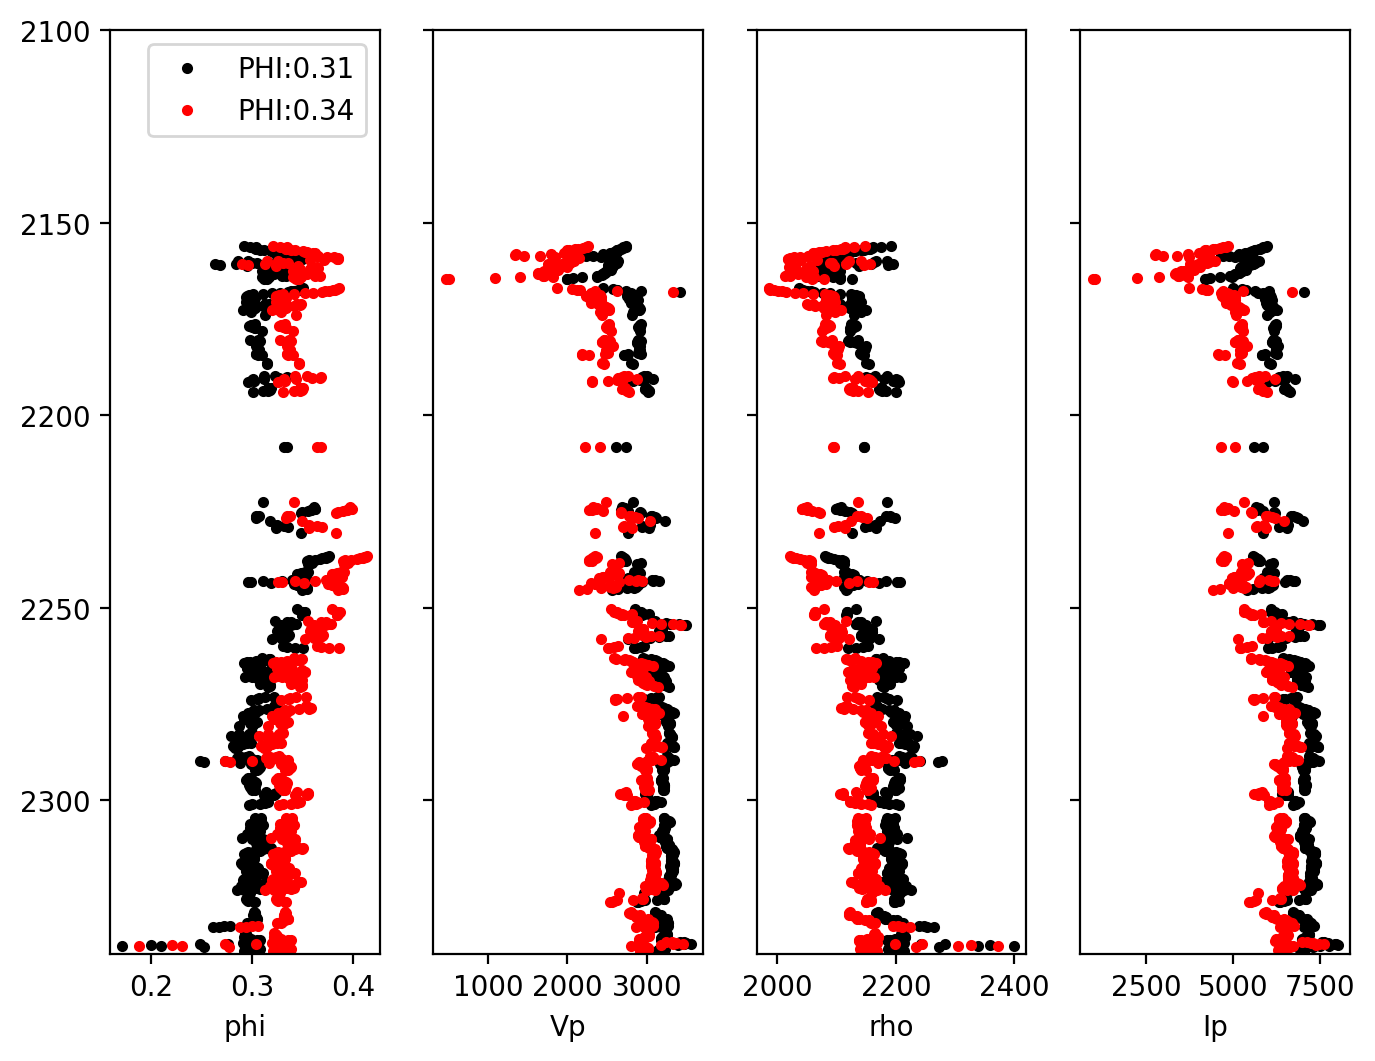

In [17]:
vp1,vs1,rho1,_,phi0,Kd0,Kd1,Kphi=porovar(LL,par=None,incr=0.1,insitu='brine',output='brine',cutoff_ss=0.2,cutoff_phi=0.0,cutoff_sw=1.0,ztop=2100,zbot=2340,qcplot=True)

# modeling with larger porosity variations; dry rock conditioning

In [18]:
def fcrit(x,c):  # Kd/k0 = 1 - phi/phi_c
    return 1 - x/c
def fstif(x,c):  # Kd/k0 = 1 / (1+ c*phi)
    return 1 / (1+c*x)
def fkrif(x,c):  # Kd/k0 = (1-phi)^ (c/(1-phi))
    return (1 -x)**(c/(1-x))
def fexp(x, c):
    return np.exp(-c * x)

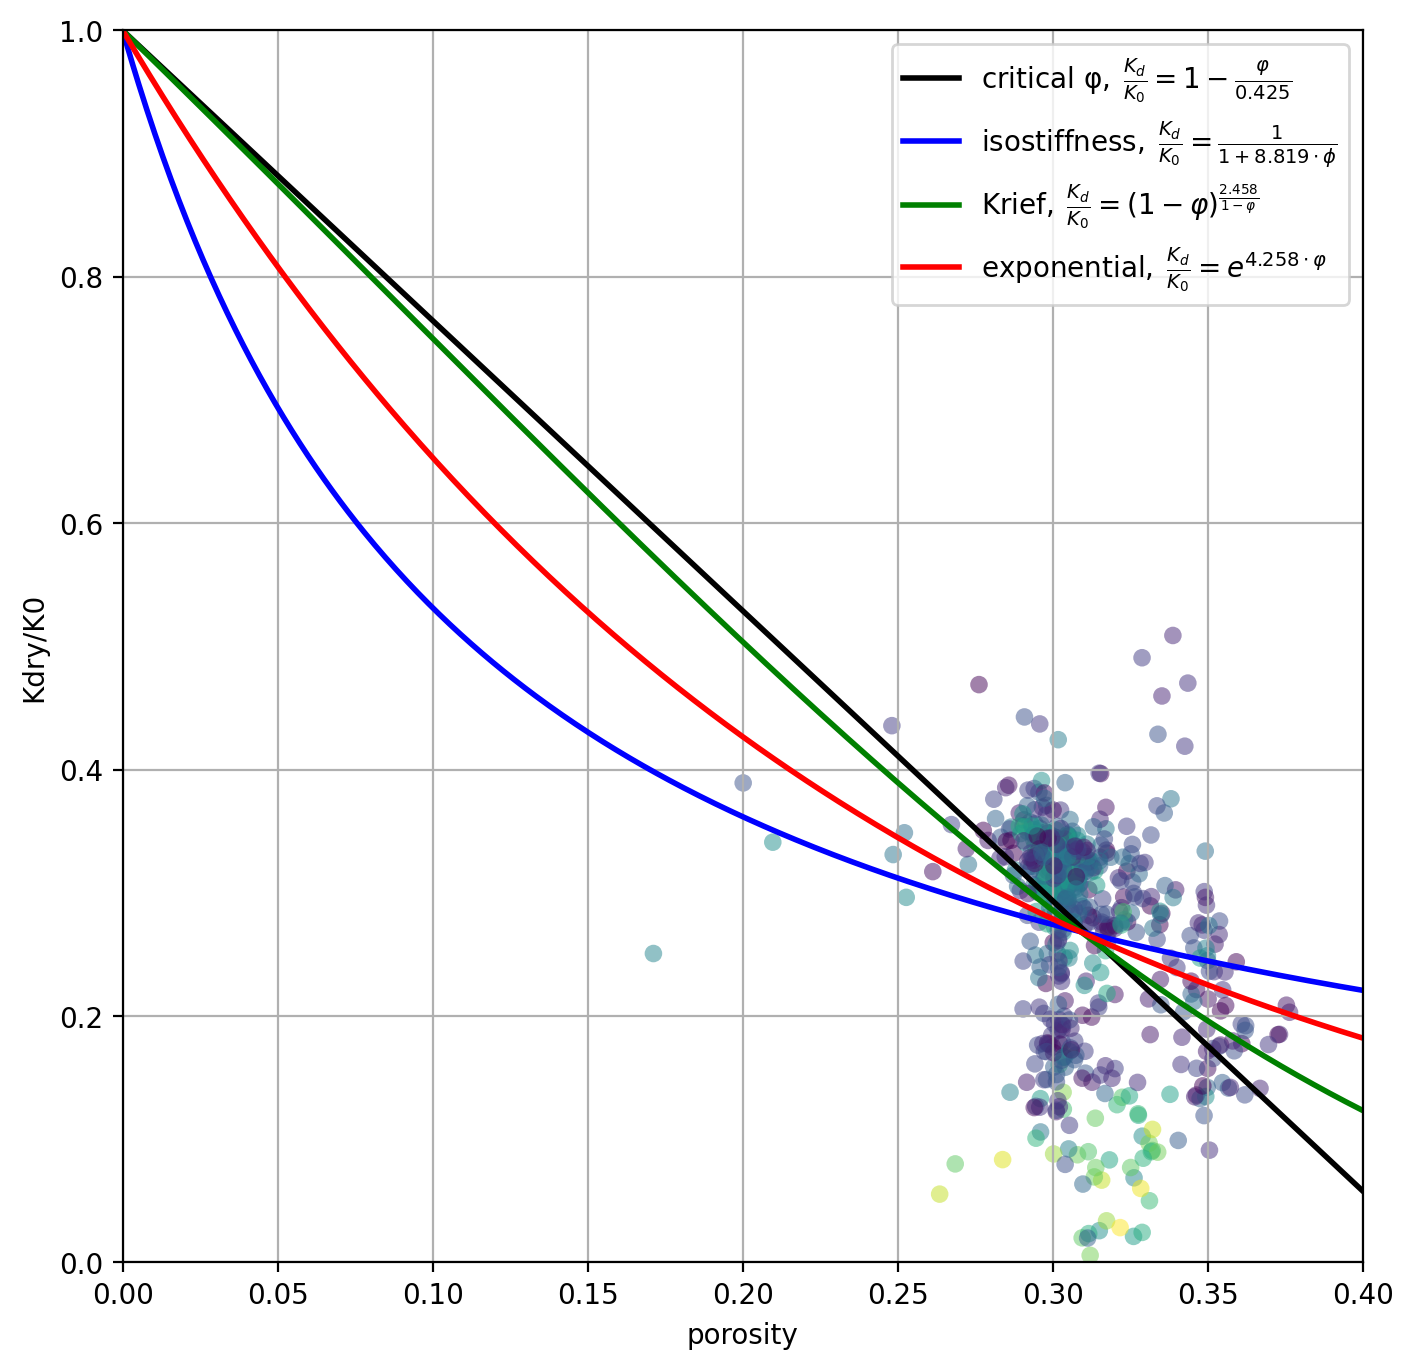

In [19]:
xx=phi
yy=Kdry/K0
fit_x=np.linspace(0,0.5,xx.size)

popt_C, pcov_C = curve_fit(fcrit, xx, yy, maxfev=10000000)
fit_y_C = fcrit(fit_x, *popt_C)
popt_S, pcov_S = curve_fit(fstif, xx, yy, maxfev=10000000)
fit_y_S = fstif(fit_x, *popt_S)
popt_K, pcov_K = curve_fit(fkrif, xx, yy, maxfev=10000000)
fit_y_K = fkrif(fit_x, *popt_K)
popt_E, pcov_E = curve_fit(fexp, xx, yy, maxfev=10000000)
fit_y_E = fexp(fit_x, *popt_E)

plt.figure(figsize=(8,8))
plt.scatter(xx, yy, 40, vsh, edgecolors='none', alpha=0.5,cmap='viridis_r')
# plt.plot(xx, yy, label='sands', **sty_ss)
plt.plot(fit_x,fit_y_C,'-k',lw=2,label=r'$\mathrm{critical\ \varphi,}\; \frac{K_d}{K_0}= 1-\frac{\varphi}{%5.3f}$' % popt_C)
plt.plot(fit_x,fit_y_S,'-b',lw=2,label=r'$\mathrm{isostiffness,}\; \frac{K_d}{K_0}= \frac{1}{1+%5.3f \cdot \phi}$' % popt_S)
plt.plot(fit_x,fit_y_K,'-g',lw=2,label=r'$\mathrm{Krief,}\; \frac{K_d}{K_0}= (1-\varphi)^\frac{%5.3f}{1-\varphi}$' % popt_K)
plt.plot(fit_x,fit_y_E,'-r',lw=2,label=r'$\mathrm{exponential,}\; \frac{K_d}{K_0}= e^{%5.3f \cdot \varphi}$' % popt_E)
plt.legend()
plt.xlabel('porosity'), plt.ylabel('Kdry/K0')
plt.xlim(0,0.4), plt.ylim(0,1)
plt.grid()

(to complete)

### non-linear trends

The elastic properties depth trends are almost certainly non-linear in real life; linear is a nice and easy approximation but almost certainly not true.

I can use `curve_fit` using arbitrary functions and modify the `sigma` vector to give more weight to a certain datapoint, so making sure that the fitted function crosses this datapoint (or at least is as close as possible).

The exponential function is the one usually seen on papers and books (_add references_):

$$ V = \frac{a}{1+c*e^{(-Z/b)}} $$

The meaning of the initial parameters given in the code below:

`curve_fit(fexp, z, vp, p0=(5000,2000,1), maxfev=9999)`

is that `p0[0]` = $a$ is the maximum velocity that you can reach, `p0[1]` = $b$ is a depth.

_I should mention that my old pal [Dario G](http://www.uwyo.edu/geolgeophys/faculty/dario-grana.html) helped me with understanding how to code and use this exponential function._

In [20]:
from scipy.optimize import curve_fit

def fpow(x, a, b):
    return a * np.power(x,b)

def flog(x, a, b):
    return a * np.log(x) + b

def fexp(z, a, b, c):
    return a / (1+c*np.exp(-z/b))

In [70]:
mask = np.arange(1000,3000)
#z[mask]
z0 = 2000
vp0 = 5000

In [80]:
vp

DEPTH
2156.0515    2732.8
2156.2041    2736.1
2156.3564    2706.5
2156.5088    2695.1
2156.6611    2660.8
              ...  
2338.4744    3226.9
2338.6267    3214.4
2338.7793    3195.4
2338.9316    3146.2
2339.0840    3138.2
Name: VP, Length: 579, dtype: float64

In [81]:
# to constrain curve_fit first I add the anchor point to the top of the log
# then create a sigma vector with a absurdly low value (=high weight)
# corresponding to this first point 
z1=np.insert(z,0,z0)
vp1=np.insert(vp.values,0,vp0)
sigma =np.ones(z1.size)
sigma[0] = 0.001

In [84]:
# constrained polynomial fit 2nd degree
p = cpf(z[mask], vp[mask], z0 , vp0, 2)
trend3 = p(zfit)

# curve_fit of function a/(1+c*exp(-z/z0))
pE, _ = curve_fit(fexp, z[mask], vp[mask], p0=(5000,2000,1), maxfev=9999)
trendE = fexp(zfit, *pE)
pEc, _ = curve_fit(fexp, z1, vp1, p0=(5000,2000,1), sigma=sigma, maxfev=9999)
trendEc = fexp(zfit, *pEc)

# curve_fit of function a*x**b
pP, _ = curve_fit(fpow, z[mask], vp[mask])
trendP = fpow(zfit, *pP)
pPc, _ = curve_fit(fpow, z1, vp1,sigma=sigma)
trendPc = fpow(zfit, *pPc)

# curve_fit of function a*log(x)+b
pL, _ = curve_fit(flog, z[mask], vp[mask])
trendL = flog(zfit, *pL)
pLc, _ = curve_fit(flog, z1, vp1,sigma=sigma)
trendLc = flog(zfit, *pLc)

NameError: name 'zfit' is not defined

NameError: name 'trendE' is not defined

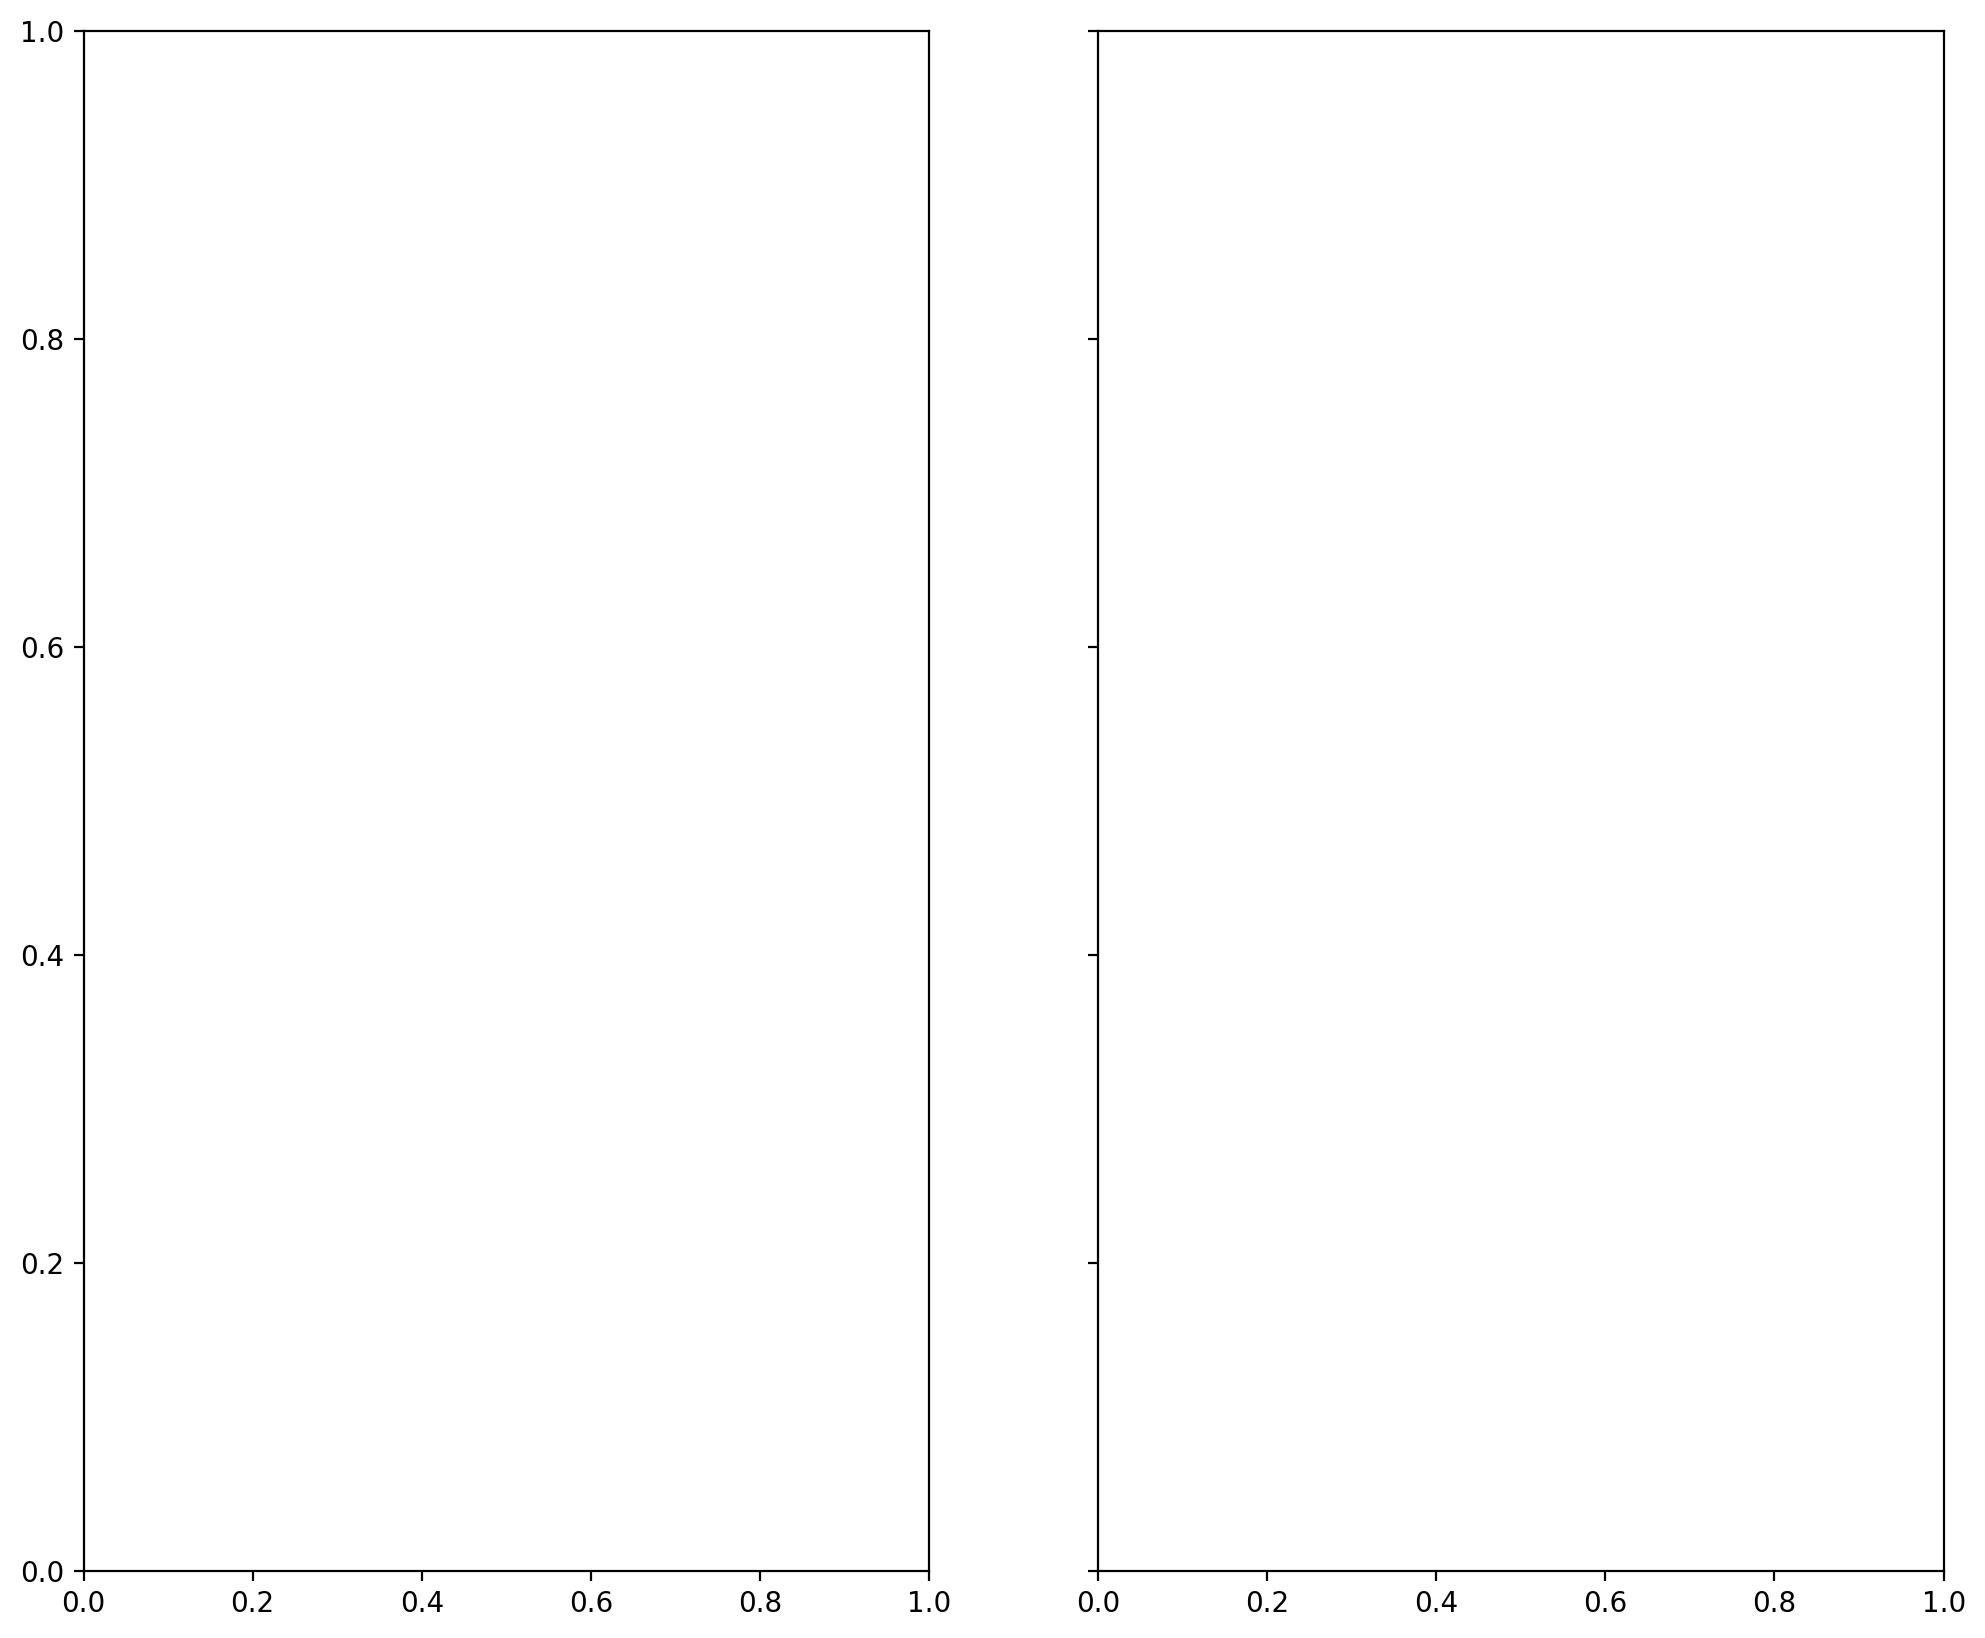

In [23]:
f, ax = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(12,10))
ax[0].plot(trendE,zfit, label='V = a/(1+c*e^(-z/b)')
ax[0].plot(trendP,zfit, label='V = a*Z^b')
ax[0].plot(trendL,zfit, label='V = a*ln(Z)+b')
ax[1].plot(trendEc,zfit, label='V = a/(1+c*e^(-z/b) constrained')
ax[1].plot(trendPc,zfit, label='V = a*Z^b constrained')
ax[1].plot(trendLc,zfit, label='V = a*ln(Z)+b constrained')
ax[0].set_title('unconstrained non-linear fits')
ax[1].set_title('constrained non-linear fits')
for aa in ax:
    aa.plot(vp,z,'k',lw=1,label='Vp')
    aa.plot(trend2,zfit,'k',lw=8, alpha=0.4,label='np.linalg.lstsq constrained')
    aa.plot(vp0,z0,'ko',ms=10)
    aa.set_ylim(3000,0)
    aa.axhline(y=z0, color='b')
    aa.legend(fontsize='medium')
    aa.grid()